In [1]:
%pylab inline
import radvel

import corner
import copy

from scipy import optimize
rc('savefig',dpi=120)

# Convenient function for plotting fits
def plot_results(like):
    fig = gcf()
    errorbar(
        like.x, like.model(t)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    plot(ti, like.model(ti))
    xlabel('Time')
    ylabel('RV')
    draw()

Populating the interactive namespace from numpy and matplotlib


Intialize Keplerian model parameters
====================================

In [2]:
params = radvel.Parameters(1,basis='per tc secosw sesinw k')
params['k1'] = radvel.Parameter(value=1)
params['per1'] = radvel.Parameter(value=1)
params['secosw1'] = radvel.Parameter(value=0.1)
params['sesinw1'] = radvel.Parameter(value=+0.2)
params['tc1'] = radvel.Parameter(value=0.)
rv_mod = radvel.RVModel(params)

Generate Synthetic Data
=======================

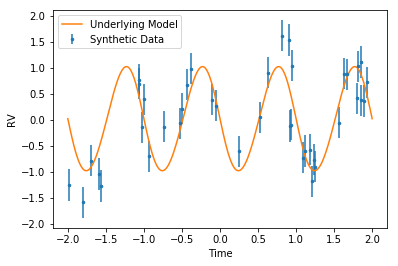

In [3]:
t = np.random.random_sample(40)
t = t * 4 - 2
t = np.sort(t)
ti = np.linspace(-2,2,400)
errvel = 0.3
jitter = 0.3
syn_rv = rv_mod(t) + randn(t.size)*np.sqrt(errvel**2 + jitter**2)
errorbar(t,syn_rv,yerr=errvel,fmt='.',label='Synthetic Data')
plot(ti,rv_mod(ti),label='Underlying Model')
xlabel('Time')
ylabel('RV')
legend()

Generate a likelihood
=====================

In [4]:
like_syn = radvel.likelihood.RVLikelihood(rv_mod,t,syn_rv,zeros(t.size)+errvel)
like_syn.params['gamma'] = radvel.Parameter(value=0)
like_syn.params['jit'] = radvel.Parameter(value=errvel)

truths = copy.deepcopy(like_syn.params) # Store away model parameters for later reference
like_syn.params.update(dict(k1=radvel.Parameter(value=3),
                            secosw1=radvel.Parameter(value=0.1),
                            sesinw1=radvel.Parameter(value=0.1),
                            tc1=radvel.Parameter(value=0.1))) # perturb the starting guess

like_syn.params['jit'].vary = False # Don't vary jitter


Perform a maximum likelihood fit
===============================

 final_simplex: (array([[ 0.9945248 , -0.01446578,  0.07865005,  0.41211866,  0.94013295,
         0.13237941, -0.04972064, -0.00354145],
       [ 0.99452128, -0.01447475,  0.07873682,  0.41212859,  0.94019059,
         0.13236868, -0.0497216 , -0.00353751],
       [ 0.99452449, -0.01447053,  0.07868819,  0.41211753,  0.94012397,
         0.13237737, -0.04972156, -0.00354026],
       [ 0.994524  , -0.01446797,  0.07861445,  0.41218586,  0.9401417 ,
         0.13239067, -0.04972568, -0.00354115],
       [ 0.99452327, -0.01447028,  0.0787384 ,  0.41211089,  0.94013384,
         0.13237028, -0.04972138, -0.00353835],
       [ 0.99452015, -0.01446463,  0.07863149,  0.41221761,  0.94009448,
         0.13238854, -0.04972738, -0.00353914],
       [ 0.99452308, -0.0144665 ,  0.07866838,  0.41216899,  0.94012579,
         0.13239709, -0.04972933, -0.00354131],
       [ 0.9945254 , -0.01446175,  0.0785933 ,  0.41218362,  0.94012512,
         0.13239114, -0.04972491, -0.00354182],
       [ 0.9945

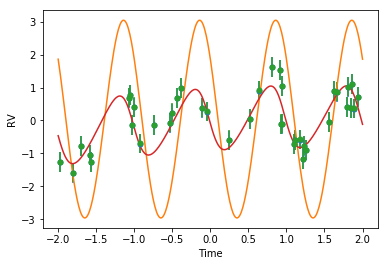

In [5]:
plot_results(like_syn) # Plot initial model
res  = optimize.minimize(like_syn.neglogprob_array, like_syn.get_vary_params(), method='Nelder-Mead' )
#res  = optimize.minimize(like_syn.neglogprob_array, like_syn.get_vary_params(), method='L-BFGS-B' )
print(res)
print(like_syn)
plot_results(like_syn) # plot best fit model

Instantiate a posterior object
===============================

In [6]:
post = radvel.posterior.Posterior(like_syn)
post.params.update(dict(per1=radvel.Parameter(value=1),
                        k1=radvel.Parameter(value=1)))
post.params['jit'].vary = True
post.priors += [radvel.prior.EccentricityPrior( 1 )]
post.priors += [radvel.prior.Gaussian( 'jit', errvel, 0.1)]
post.priors += [radvel.prior.Gaussian( 'per1', 1, 0.1)]
post.priors += [radvel.prior.Gaussian( 'tc1', 0, 0.1)]

post.priors += [radvel.prior.SecondaryEclipsePrior(1, 0.5, 0.01)]

print(post.priors)
print(post)

[e1 constrained to be < 0.99, Gaussian prior on jit, mu=0.3, sigma=0.1, Gaussian prior on per1, mu=1, sigma=0.1, Gaussian prior on tc1, mu=0, sigma=0.1, secondary eclipse constraint: 0.5 +/- 0.01]
parameter                     value      vary
per1                              1       True
tc1                      -0.0144658       True
secosw1                     0.07865       True
sesinw1                    0.412119       True
k1                                1       True
dvdt                       0.132379       True
curv                     -0.0497206       True
gamma                   -0.00354145       True
jit                             0.3       True

Priors
------
e1 constrained to be < 0.99
Gaussian prior on jit, mu=0.3, sigma=0.1
Gaussian prior on per1, mu=1, sigma=0.1
Gaussian prior on tc1, mu=0, sigma=0.1
secondary eclipse constraint: 0.5 +/- 0.01



Perform maximum likelihood fit on posterior
=========================================

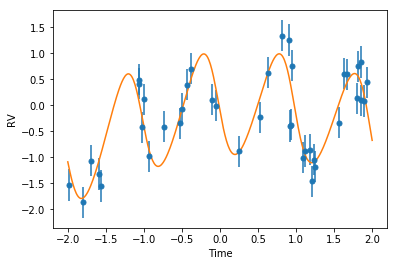

In [7]:
res  = optimize.minimize(post.neglogprob_array, post.get_vary_params(), method='Nelder-Mead' )
plot_results(post.likelihood)

Use mcmc to sample the posterior distribution
========================

1. use `emcee` package to run MCMC
1. corner plot visualizes parameters and correlations
1. Blue lines show the synthetic model parameters

In [8]:
df = radvel.mcmc(post,nwalkers=20,nrun=1000)

16000/160000 (10.0%) steps complete; Running 6867.19 steps/s; Mean acceptance rate = 45.0%; Min Tz = 1073.1; Max G-R = 1.027      
Discarding burn-in now that the chains are marginally well-mixed

96000/160000 (60.0%) steps complete; Running 7384.99 steps/s; Mean acceptance rate = 40.0%; Min Tz = 3523.6; Max G-R = 1.008      
Chains are well-mixed after 96000 steps! MCMC completed in 15.8 seconds




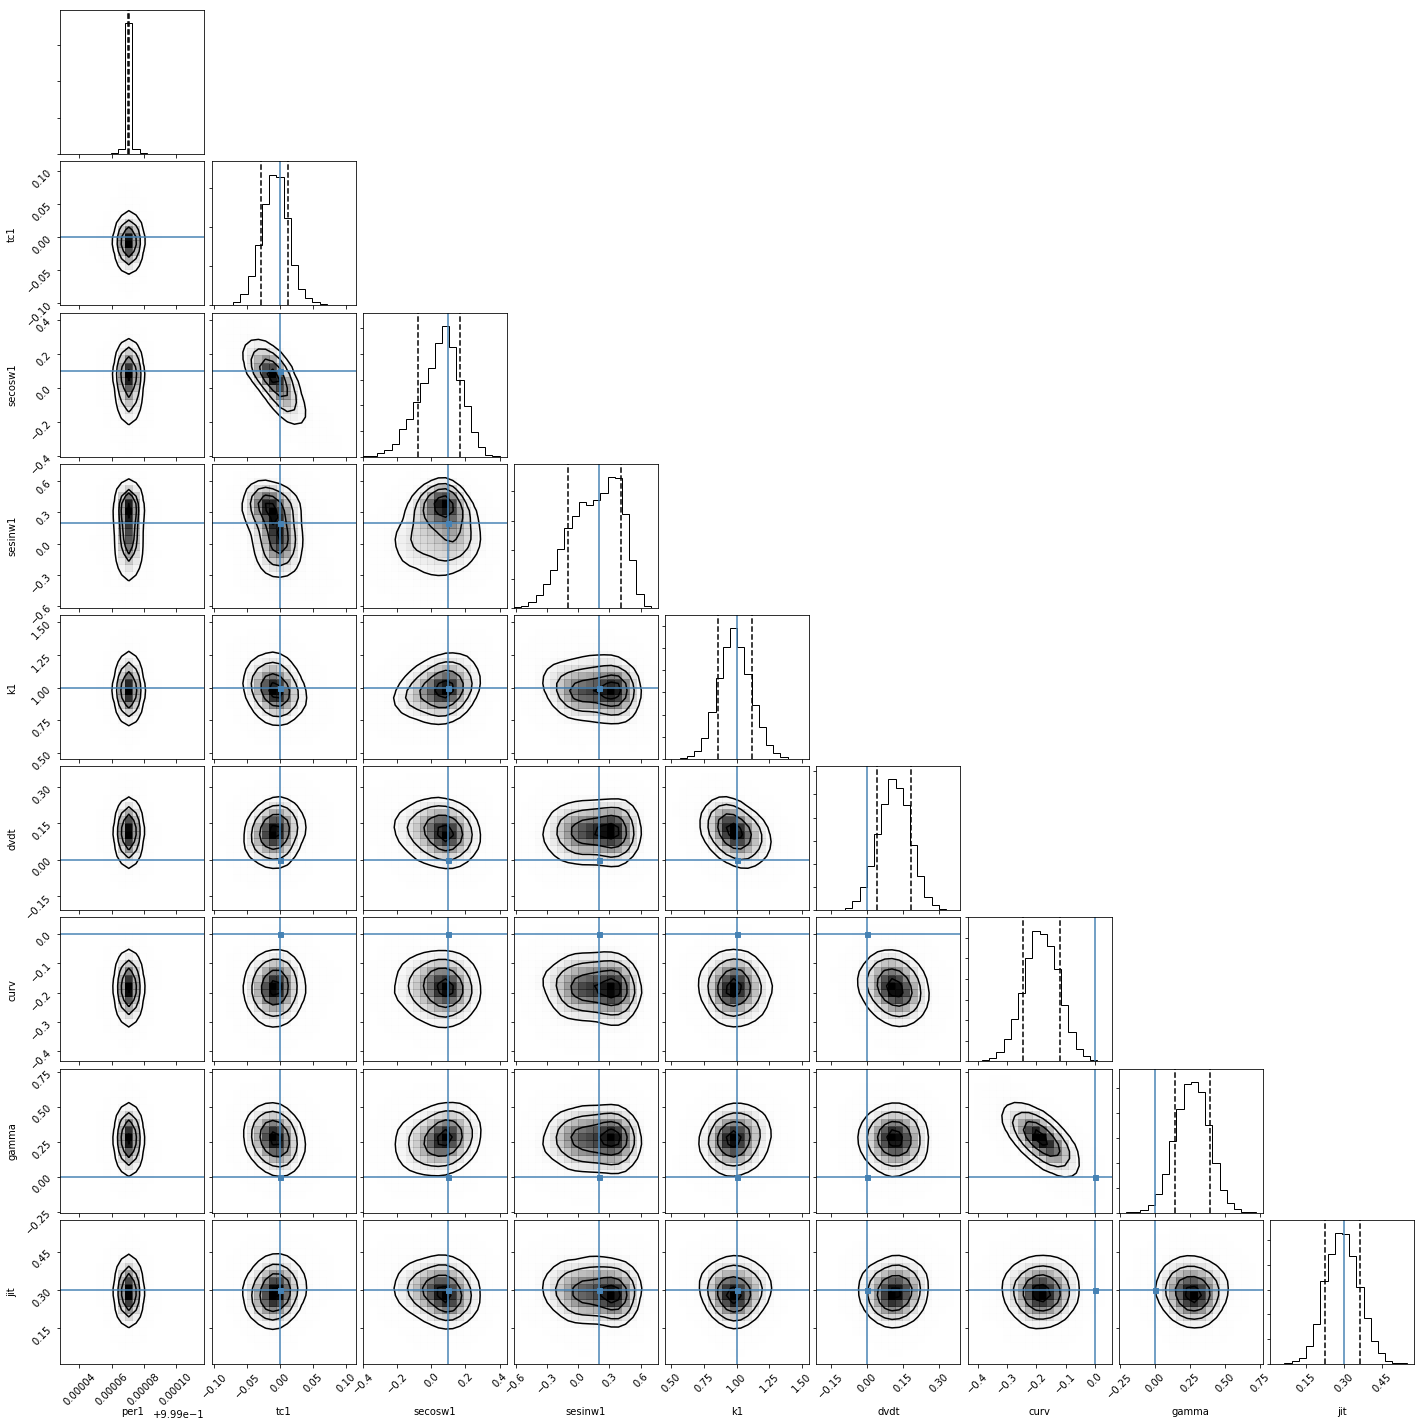

In [9]:
labels = [k for k in post.params.keys() if post.params[k].vary]



fig = corner.corner(
    df[labels],
    labels=labels,
    truths=[truths[k].value for k in labels ],
    quantiles=[0.15,0.85],
    plot_datapoints=False,
    smooth=True,
    bins=20
    )

(array([6.0000e+00, 7.0000e+00, 4.1000e+01, 2.1300e+02, 8.0900e+02,
        2.6910e+03, 9.6300e+03, 2.4072e+04, 3.2807e+04, 9.7240e+03]),
 array([-39.86048858, -37.7236317 , -35.58677481, -33.44991793,
        -31.31306104, -29.17620416, -27.03934728, -24.90249039,
        -22.76563351, -20.62877662, -18.49191974]),
 <a list of 10 Patch objects>)

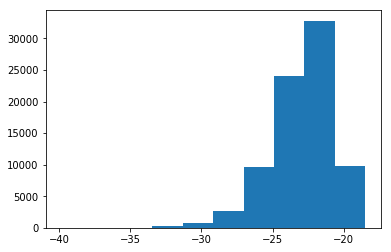

In [10]:
hist(df.lnprobability)